In [39]:
import pickle
import sys
from typing import cast

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import torch

sys.path.append("..")
from NGS.ema import EMA
from NGS.hyperparameter import HyperParameter
from path import DATA_DIR, RESULT_DIR
from traffic.data import StandardScaler, TrafficDataset, preprocess
from traffic.experiment import rollout
from traffic.model import TrafficModel

device = torch.device("cuda")

In [43]:
def inverse_transform(x: torch.Tensor, scaler: StandardScaler) -> torch.Tensor:
    return scaler.inverse_transform(x.reshape(-1, 1)).reshape(x.shape)


def mape(
    pred_trajectory: npt.NDArray[np.float32],
    true_trajectory: npt.NDArray[np.float32],
    eps: float = 1e-4,
) -> float:
    mask = true_trajectory > eps
    mape = np.abs(
        np.divide(
            pred_trajectory - true_trajectory,
            true_trajectory,
            out=np.zeros_like(pred_trajectory),
            where=mask,
        )
    )
    mask = mask.astype(np.float32) / mask.mean(dtype=np.float32)
    return (mape * mask).mean() * 100


def evaluate(exp_id: str, windows: list[int] = [3, 6, 12]) -> None:
    result_dir = RESULT_DIR / exp_id
    hp = HyperParameter.from_yaml(result_dir / "hyperparameter.yaml")

    df = cast(pd.DataFrame, pd.read_hdf(DATA_DIR / "PEMS-BAY/pems-bay.h5"))
    *_, adj = pd.read_pickle(DATA_DIR / "PEMS-BAY/adj_mx_bay.pkl")
    preprocessed = preprocess(df, adj)

    trajectory = preprocessed["trajectory"]
    time_in_day = preprocessed["time_in_day"]
    day_in_week = preprocessed["day_in_week"]
    edge_indices = preprocessed["edge_index"]
    edge_attrs = preprocessed["edge_attr"]
    indicies_test = preprocessed["indicies_test"]
    scaler = preprocessed["scaler"]

    # Dataset for test
    test_dataset = TrafficDataset(
        trajectory, time_in_day, day_in_week, indicies_test, edge_indices, edge_attrs
    )
    true_trajectories = {
        window: torch.cat(
            [data.y[..., window - 1] for data in test_dataset.data], dim=0
        )
        for window in windows
    }

    # Model
    checkpoint = torch.load(result_dir / "checkpoint.pth")
    num_nodes = trajectory.shape[1]
    model = TrafficModel(num_nodes, hp.emb_dim, hp.depth, hp.dropout).to(device)
    ema = EMA(model)
    ema.load_state_dict(checkpoint["ema"])

    # Rollout
    with ema():
        pred_trajectories = rollout(model, test_dataset, device, out_windows=windows)

    true_trajectory_3 = inverse_transform(true_trajectories[3], scaler).cpu().numpy()
    true_trajectory_6 = inverse_transform(true_trajectories[6], scaler).cpu().numpy()
    true_trajectory_12 = inverse_transform(true_trajectories[12], scaler).cpu().numpy()

    pred_trajectory_3 = inverse_transform(pred_trajectories[3], scaler).cpu().numpy()
    pred_trajectory_6 = inverse_transform(pred_trajectories[6], scaler).cpu().numpy()
    pred_trajectory_12 = inverse_transform(pred_trajectories[12], scaler).cpu().numpy()

    test_mae_3 = np.abs(pred_trajectory_3 - true_trajectory_3).mean()
    test_rmse_3 = np.sqrt(np.square(pred_trajectory_3 - true_trajectory_3).mean())
    test_mape_3 = mape(pred_trajectory_3, true_trajectory_3)
    print("window: 3", end="\t")
    print(f"{test_mae_3:.2f}", end="\t")
    print(f"{test_rmse_3:.2f}", end="\t")
    print(f"{test_mape_3:.2f}")

    test_mae_6 = np.abs(pred_trajectory_6 - true_trajectory_6).mean()
    test_rmse_6 = np.sqrt(np.square(pred_trajectory_6 - true_trajectory_6).mean())
    test_mape_6 = mape(pred_trajectory_6, true_trajectory_6)
    print("window: 6", end="\t")
    print(f"{test_mae_6:.2f}", end="\t")
    print(f"{test_rmse_6:.2f}", end="\t")
    print(f"{test_mape_6:.2f}")

    test_mae_12 = np.abs(pred_trajectory_12 - true_trajectory_12).mean()
    test_rmse_12 = np.sqrt(np.square(pred_trajectory_12 - true_trajectory_12).mean())
    test_mape_12 = mape(pred_trajectory_12, true_trajectory_12)
    print("window: 12", end="\t")
    print(f"{test_mae_12:.2f}", end="\t")
    print(f"{test_rmse_12:.2f}", end="\t")
    print(f"{test_mape_12:.2f}")

    # Save results
    with open(result_dir / "pred_trajectory.pkl", "wb") as f:
        pickle.dump(
            {
                3: pred_trajectory_3,
                6: pred_trajectory_6,
                12: pred_trajectory_12,
            },
            f,
        )

best_epoch 124


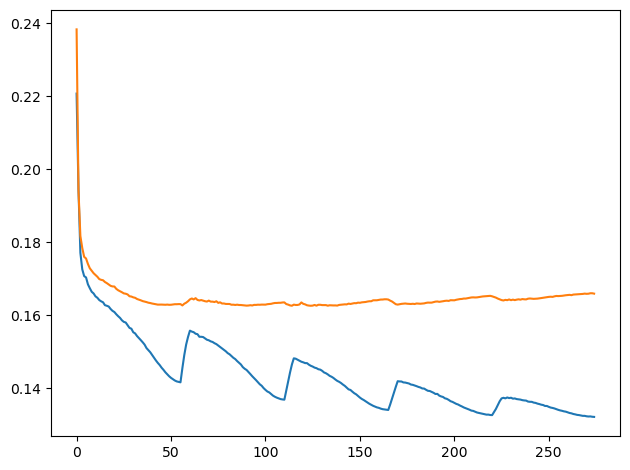

In [44]:
exp_id = "traffic"
result_dir = RESULT_DIR / exp_id
loss_df = pd.read_csv(result_dir / "loss.txt", sep="\t")

fig, ax = plt.subplots()
ax.plot(loss_df.train_mae)
ax.plot(loss_df.val_mae)
print(f"best_epoch {loss_df.val_mae.idxmin()}")

fig.tight_layout()
fig.show()

In [45]:
evaluate(exp_id)

window: 3	1.29	2.79	2.71
window: 6	1.60	3.70	3.61
window: 12	1.86	4.35	4.36
